# Cytosol Only Cellpose Segmentation

In [1]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

/Users/sophia/mambaforge/envs/scportrait_test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_location = "project_cytosol_only"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example1.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[27/02/2025 18:05:20] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only/config.yml
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_on
         ly/scportrait.sdata                                                                                       
[27/02/2025 18:05:20] Compression algorithm for extracted single-cell images: lzf
[27/02/2025 18:05:20] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1.


In [3]:
from scportrait.data._datasets import dataset_1

dataset_1_path = dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

[27/02/2025 18:05:20] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_b5m3khcl for Project
[27/02/2025 18:05:24] Image input_image written to sdata object.
[27/02/2025 18:05:25] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_b5m3khcl'>


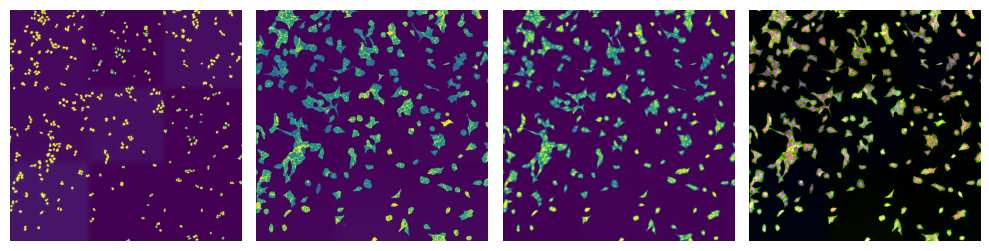

In [4]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

from scportrait.plotting.vis import generate_composite

fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

In [5]:
project.segment()

[27/02/2025 18:05:44] GPU Status for segmentation is True and will segment using the following device mps.
[27/02/2025 18:05:44] Segmentation will be performed wtih all 1 found GPUs.
[27/02/2025 18:05:44] GPU Status for segmentation is True with 1 GPUs found. Segmentation will be performed on the device mps with 1 processes per device in parallel.
[27/02/2025 18:05:45] Segmenting cytosol using the following model: cyto2
[27/02/2025 18:06:01] Segmentation seg_all_cytosol written to sdata object.
[27/02/2025 18:06:03] Points centers_seg_all_cytosol written to sdata object.


(-0.5, 3036.5, 3038.5, -0.5)

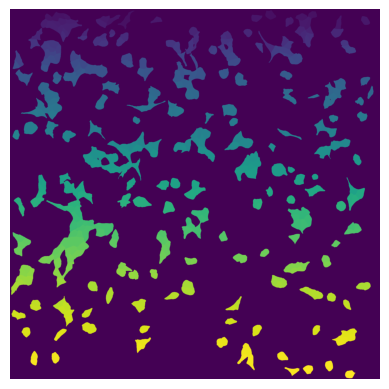

In [6]:
plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [7]:
project.extract()

[27/02/2025 18:06:04] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/HDF5CellExtraction_xk1q9d_6 for HDF5CellExtraction
[27/02/2025 18:06:04] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only/extraction/data
[27/02/2025 18:06:04] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only/extraction/data
[27/02/2025 18:06:04] Found 1 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_cytosol']
[27/02/2025 18:06:04] Using seg_all_cytosol as the main segmentation mask to determine cell centers.
[27/02/2025 18:06:04] A total of 9 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/exampl

Extracting cell batches: 100%|██████████| 5/5 [00:00<00:00, 19.73it/s]


[27/02/2025 18:06:05] Finished extraction in 0.50 seconds (890.34 cells / second)
[27/02/2025 18:06:05] Benchmarking times saved to file.
[27/02/2025 18:06:05] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/HDF5CellExtraction_xk1q9d_6'>


(444, 4, 128, 128)


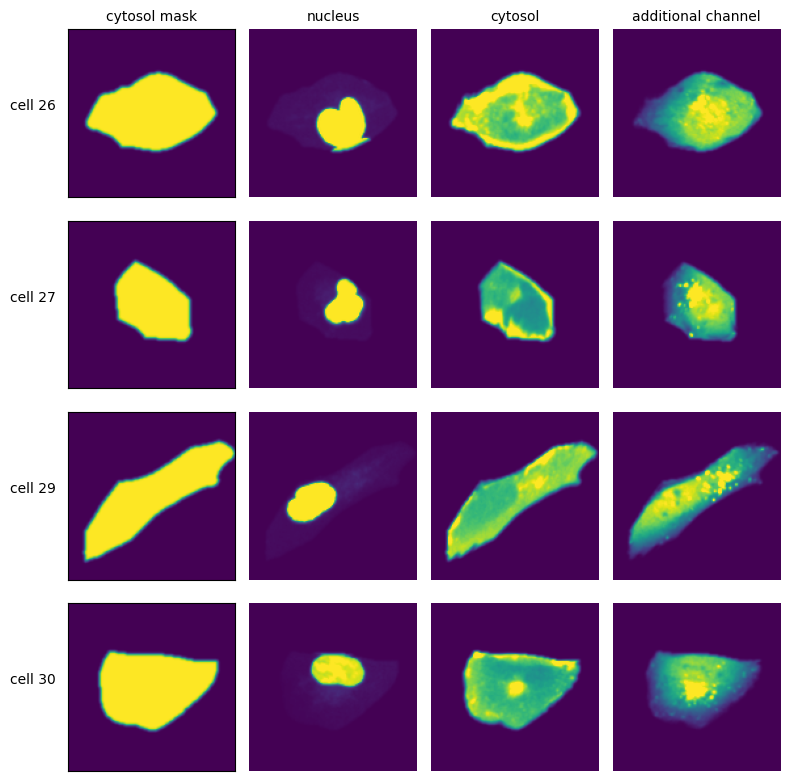

In [8]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 4, figsize=(4 * 2, len(n_cells) * 2))
    labels = ["cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)
    fig.tight_layout()

In [9]:
project.featurize()

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only/extraction/data/single_cells.h5
[27/02/2025 18:06:05] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_4ravjy9n for CellFeaturizer
[27/02/2025 18:06:05] Started CellFeaturization of all available channels.
[27/02/2025 18:06:05] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only/featurization/complete_CellFeaturizer
[27/02/2025 18:06:05] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[27/02/2025 18:06:05] Reading data from path: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only/extraction/data/single_cells.h5
[27/02/2025 18:06:05] Dataloader gen

In [10]:
# load classification results
results = pd.read_csv(f"{project_location}/featurization/complete_CellFeaturizer/calculated_image_features.csv")
results

,cytosol_area,1_mean_cytosol,1_median_cytosol,1_quant75_cytosol,1_quant25_cytosol,1_summed_intensity_cytosol,1_summed_intensity_area_normalized_cytosol,2_mean_cytosol,2_median_cytosol,2_quant75_cytosol,...,2_summed_intensity_cytosol,2_summed_intensity_area_normalized_cytosol,3_mean_cytosol,3_median_cytosol,3_quant75_cytosol,3_quant25_cytosol,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,label,cell_id
0,6927.0,0.074052,0.0,0.026459,0.0,1213.26010,0.175149,0.240117,0.0,6.782227e-01,...,3934.0850,0.567935,0.138888,0.0,1.565247e-01,0.0,2275.5398,0.328503,0,22
1,3981.0,0.055688,0.0,0.000000,0.0,912.39026,0.229186,0.111980,0.0,0.000000e+00,...,1834.6765,0.460858,0.103961,0.0,0.000000e+00,0.0,1703.2891,0.427855,0,25
2,5229.0,0.076646,0.0,0.019680,0.0,1255.77270,0.240155,0.204406,0.0,1.302185e-01,...,3348.9832,0.640463,0.154911,0.0,3.311920e-02,0.0,2538.0576,0.485381,0,26
3,3442.0,0.046036,0.0,0.000000,0.0,754.24817,0.219131,0.105017,0.0,0.000000e+00,...,1720.6058,0.499885,0.093497,0.0,0.000000e+00,0.0,1531.8601,0.445049,0,27
4,5463.0,0.057873,0.0,0.008547,0.0,948.19820,0.173567,0.182684,0.0,9.886169e-02,...,2993.1000,0.547886,0.133167,0.0,1.339340e-02,0.0,2181.8086,0.399379,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,4209.0,0.034690,0.0,0.000000,0.0,568.36804,0.135036,0.142048,0.0,2.533197e-07,...,2327.3137,0.552937,0.095533,0.0,5.960465e-08,0.0,1565.2133,0.371873,0,496
440,3285.0,0.059075,0.0,0.000000,0.0,967.88170,0.294637,0.102969,0.0,0.000000e+00,...,1687.0396,0.513558,0.082061,0.0,0.000000e+00,0.0,1344.4890,0.409281,0,497
441,5578.0,0.038588,0.0,0.001783,0.0,632.22570,0.113343,0.203797,0.0,2.258301e-01,...,3339.0146,0.598604,0.124447,0.0,1.148605e-02,0.0,2038.9376,0.365532,0,498
442,5595.0,0.052219,0.0,0.002640,0.0,855.55725,0.152915,0.178292,0.0,3.445435e-01,...,2921.1382,0.522098,0.134353,0.0,4.961395e-02,0.0,2201.2330,0.393429,0,499


In [11]:
#test selection workflow
selected_cells_large = results[results.cytosol_area > 4500]["cell_id"].tolist()
selected_cells_small = results[results.cytosol_area < 3000]["cell_id"].tolist()

cells_to_select = [
    {"name": "large_cells", "classes": selected_cells_large, "well": "A1"},
    {"name": "small_cells", "classes": selected_cells_small, "well": "B1"},
]

marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])


[27/02/2025 18:06:07] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/LMDSelection_pbukodte for LMDSelection
[27/02/2025 18:06:07] Selection process started.


Processing cell batches: 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]


[27/02/2025 18:06:15] Temporary directory not found, skipping cleanup
[27/02/2025 18:06:15] Temporary directory not found, skipping cleanup
[27/02/2025 18:06:15] Temporary directory not found, skipping cleanup
[27/02/2025 18:06:16] Coordinate lookup index calculation took 8.733680958859622 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in parall

dilating shapes: 100%|██████████| 208/208 [00:07<00:00, 29.03it/s]


0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 34/34 [00:05<00:00,  6.72it/s]


0 shapes that were intersecting were found and merged.


creating shapes:   0%|          | 0/81 [00:00<?, ?it/s]

Current path length: 34,667.38 units
Optimized path length: 15,473.04 units
Optimization factor: 2.2x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets:  50%|█████     | 1/2 [00:20<00:20, 20.97s/it]

calculating polygons: 100%|██████████| 81/81 [00:11<00:00,  7.24it/s]


Current path length: 82,683.68 units
Optimized path length: 27,214.13 units
Optimization factor: 3.0x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.
collecting cell sets: 100%|██████████| 2/2 [00:34<00:00, 17.01s/it]


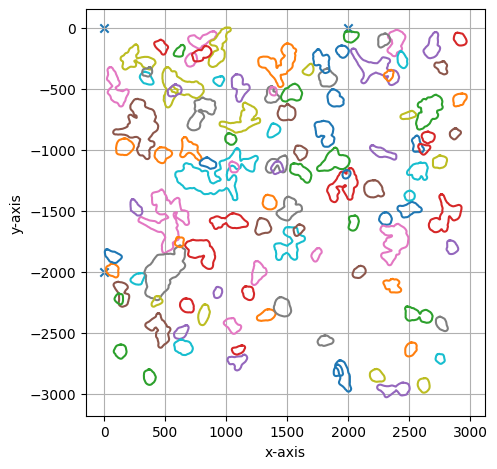

===== Collection Stats =====
Number of shapes: 115
Number of vertices: 16,789
Mean vertices: 146
Min vertices: 60
5% percentile vertices: 71
Median vertices: 103
95% percentile vertices: 332
Max vertices: 700
[0 0]
[      0 -200000]
[200000      0]
[27/02/2025 18:06:50] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only/selection/large_cells_small_cells.xml
[27/02/2025 18:06:51] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/LMDSelection_pbukodte'>


In [12]:
project.selection_f.segmentation_channel_to_select = "seg_all_cytosol" #update to the correct channel for this notebook with out loading a different config
project.select(cells_to_select, calibration_marker)